CSE 546 - Reinforcement Learning
# Assignment 3 - Actor critic
Author: @sivashanmugamo

## Pre-requisites

In [95]:
#!pip3 install box2d-py > /dev/null 2>&1

Importing required libraries

In [96]:
import math, time, random, pickle
import numpy as np
from scipy.interpolate import make_interp_spline
from matplotlib import pyplot as plt

import gym
from gym import spaces

import torch
from torch import nn, optim, autograd

Checking for GPU availability

In [97]:
DEVICE= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Environment

Global Initiations

In [98]:
ENV_1= 'CartPole-v1'
ENV_2= 'LunarLander-v2'

Initializing the positions of the agent, goal, and rewards

In [99]:
AGENT_POS= [0, 0]
DIAMOND_POS= [1, 3]
COIN_POS= [3, 2]
MONSTER_POS= [2, 1]
GOAL_POS= [3, 3]

Pre-defining the minimum number of states and actions that will be used in the environment

In [100]:
N_STATES= 16
N_ACTIONS= 4
MAX_TIMESTEPS= 50

Initializing lookup dictionaries for states & actions

In [101]:
STATE_LOOKUP= dict()
ACTION_LOOKUP= {0: 'Down', 1: 'Up', 2: 'Right', 3: 'Left'}

k= 0
for i in range(4):
  for j in range(4):
    STATE_LOOKUP[(i, j)]= k
    k+= 1

Defining a simple grid environment

In [102]:
class SimpleGrid(gym.Env):
  metadata= {'render.modes': []}

  def __init__(self):
    '''
    Initializes the number of states, action, & maximum timestep of the environment
    '''

    self.observation_space= spaces.Discrete(N_STATES)
    self.action_space= spaces.Discrete(N_ACTIONS)
    self.max_timesteps= MAX_TIMESTEPS

  def reset(self):
    '''
    Resets the environment to its default setup

    Output:
      observation: 2-element list - Coordinates of the agent's default position in the grid
    '''

    self.timestep= 0

    self.agent_pos= AGENT_POS.copy()
    self.diamond_pos= DIAMOND_POS.copy()
    self.coin_pos= COIN_POS.copy()
    self.monster_pos= MONSTER_POS.copy()
    self.goal_pos= GOAL_POS.copy()

    self.state= np.zeros((4, 4))

    self.state[tuple(self.agent_pos)]= 1
    self.state[tuple(self.diamond_pos)]= 5
    self.state[tuple(self.coin_pos)]= 3
    self.state[tuple(self.monster_pos)]= -5
    self.state[tuple(self.goal_pos)]= 10
    
    agent_state= self.agent_pos

    return STATE_LOOKUP[tuple(agent_state)]

  def step(self, action: int):
    '''
    1. Moves the agent as per the given action
    2. Sets the rewards per state in the environment
    3. Calculates the reward of the new state

    Input:
      action: int - Action to be performed

    Output:
      action: int - Action taken
      observation: 2-element list
      reward: int - State reward
      done: bool - Denotes if the learning is complete (or) goal is reached
      info: dict
    '''

    # Initializing the grid
    self.state= np.zeros((4, 4))

    # Move the agent
    if action == 0: # Go down one step
      self.agent_pos[0] += 1
    if action == 1: # Go up one step
      self.agent_pos[0] -= 1
    if action == 2: # Go right one step
      self.agent_pos[1] += 1
    if action == 3: # Go left one step
      self.agent_pos[1] -= 1

    # To keep the agent within the confines of the environment
    self.agent_pos= np.clip(self.agent_pos, 0, 3)

    # Initialize the state rewards
    self.state[tuple(self.agent_pos)]= 1
    self.state[tuple(self.diamond_pos)]= 5
    self.state[tuple(self.coin_pos)]= 3
    self.state[tuple(self.monster_pos)]= -5
    self.state[tuple(self.goal_pos)]= 10

    agent_state= self.agent_pos

    # Calculates the reward for the action
    reward= 0
    if (self.agent_pos == self.diamond_pos).all():
      reward += 5
    if (self.agent_pos == self.coin_pos).all():
      reward += 3
    if (self.agent_pos == self.monster_pos).all():
      reward -= 5
    if (self.agent_pos == self.goal_pos).all():
      reward += 10

    # Timestep increment
    self.timestep += 1

    done= True if ((self.timestep >= self.max_timesteps) or (self.agent_pos == self.goal_pos).all()) else False
    info= {}

    return STATE_LOOKUP[tuple(agent_state)], reward, done, info

  def render(self):
    '''
    Provides pictorial representation of environment
    '''

    plt.imshow(self.state)

## Advantage Actor Critic

Initiating a class for the actor-critic network

In [103]:
class AC(nn.Module):
  def __init__(self, env, n_input: int, n_output: int, 
               n_hidden: int= 256, learning_rate: float= 1e-3) -> None:
    super(AC, self).__init__()

    self.env= env

    # Observation space size
    self.n_input= n_input
    self.n_hidden= n_hidden

    # Action space size
    self.n_output= n_output

    self.alpha= learning_rate

    # Critic model
    # Predicts value
    self.critic= nn.Sequential(
        nn.Linear(self.n_input, self.n_hidden), 
        nn.ReLU(), 
        nn.Linear(self.n_hidden, 1)
    )

    # Actor network
    # Predicts policy distribution
    self.actor= nn.Sequential(
        nn.Linear(self.n_input, self.n_hidden), 
        nn.ReLU(),  
        nn.Linear(self.n_hidden, self.n_output), 
        nn.Softmax(dim= 1)
    )

  def forward(self, state: np.array) -> tuple:
    '''
    Predicts the value & probability distribution of action based 
    on the state
    '''

    state= autograd.Variable(torch.from_numpy(state).float().unsqueeze(0))
    return (self.critic(state), self.actor(state))

To plot the reward per episode graph

In [104]:
def plot_result(rewards: list) -> None:
      plt.title('Reward per episode')
      plt.plot(rewards)
      plt.xlabel('# Episodes')
      plt.ylabel('Rewards')
      plt.show()

Agent function that runs for 100 timesteps for every one of 1000 episodes by default

In [105]:
def A2C(env, discount_rate: float= 0.99, max_timesteps: int= 100, 
        max_episodes: int= 1000, verbose: bool= False):
  n_input= env.observation_space.shape[0]
  n_output= env.action_space.n

  gamma= discount_rate

  # Initiating model
  ac= AC(
      env= env,
      n_input= n_input, 
      n_output= n_output
  )

  # Initiatig optimizer
  optimizer= optim.Adam(ac.parameters(), lr= ac.alpha)

  episode_reward_list= list()
  entropy= 0
  for each_episode in range(max_episodes):
    rewards_list= list()
    values_list= list()
    log_prob_list= list()

    state= env.reset()
    for each_timestep in range(max_timesteps):
      value, policy= ac.forward(state)

      value= value.detach().numpy()[0, 0]
      dist= policy.detach().numpy()

      # Choosing action
      action= np.random.choice(n_output, p= np.squeeze(dist))
      log_prob= torch.log(policy.squeeze(0))[action]
      entropy+= (-1) * np.sum(np.mean(dist) * np.log(dist))

      # Perform a_t according to policy\pi(a_t|s_t; \theta)
      # Receive reward r_t & new state s_{t+1}
      next_state, reward, done, info= env.step(action)
      state= next_state

      rewards_list.append(reward)
      values_list.append(value)
      log_prob_list.append(log_prob)

      # Until terminal s_t or t - t_{\text{start}} == t_{\text{max}}
      if done or (each_timestep + 1 == max_timesteps):
        Q= ac.forward(next_state)[0].detach().numpy()[0, 0]
        episode_reward_list.append(np.sum(rewards_list))
        if (each_episode % 10) == 0 and verbose:
          print('At episode {}, reward is {}'.format(
              each_episode, np.sum(rewards_list)))
        break

    Q_values= torch.zeros_like(torch.Tensor(values_list))
    for i in reversed(range(len(rewards_list))):
      Q= rewards_list[i] + gamma * Q
      Q_values[i]= Q

    # Updating network
    value_t= torch.FloatTensor(values_list)
    Q_t= Q_values.float()
    log_prob_t= torch.stack(log_prob_list)

    # Advantage: A(s, a)= Q(s, a) - V(s)
    advantage_t= Q_t - value_t

    # Loss functions
    actor_loss= (-1) * (log_prob_t * advantage_t).mean()
    critic_loss= 0.5 * advantage_t.pow(2).mean()

    ac_loss= actor_loss + critic_loss + (0.001 * entropy)

    optimizer.zero_grad()
    ac_loss.backward()
    optimizer.step()
  
  plot_result(rewards= episode_reward_list)

## Environment runs

Performance of specified environment 1

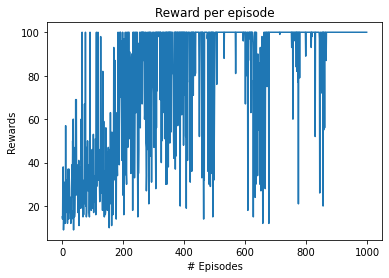

In [109]:
env_1= gym.make(ENV_1)
A2C(env= env_1)

Performance of specified environment 2

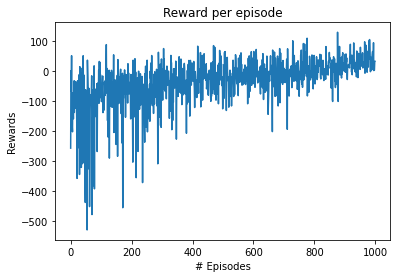

In [107]:
env_2= gym.make(ENV_2)
A2C(env= env_2)

## References
1. Advantage Actor Critic (A2C) Pseudocode - https://www.researchgate.net/figure/Pseudo-code-for-advantage-actor-critic-algorithm_fig8_325129154
2. An intro to Advantage Actor Critic methods - https://www.freecodecamp.org/news/an-intro-to-advantage-actor-critic-methods-lets-play-sonic-the-hedgehog-86d6240171d/
2. Intuitive RL: Intro to Advantage-Actor-Critic (A2C) - https://hackernoon.com/intuitive-rl-intro-to-advantage-actor-critic-a2c-4ff545978752
3. The idea behind Actor-Critics and how A2C and A3C improve them - https://theaisummer.com/Actor_critics/
4. Reinforcement Learning 6: Policy Gradients and Actor Critics - https://youtu.be/bRfUxQs6xIM
5. Asynchronous Methods for Deep Reinforcement Learning - https://arxiv.org/pdf/1602.01783.pdf
6. Lilian Weng blog: Policy Gradient Algorithms - https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html